Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

=== Simulation 1/10 ===

  -> K = 4
    [View 1/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    [View 2/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    [View 3/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    [View 4/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    nt_frac=0.10 (n= 1225) | CF: cov=0.899, size=3.629 | AdjF: cov=0.900, size=3.710
    nt_frac=0.20 (n= 2450) | CF: cov=0.904, size=3.579 | AdjF: cov=0.902, size=3.724
    nt_frac=0.30 (n= 3675) | CF: cov=0.904, size=3.514 | AdjF: cov=0.903, size=3.756
    nt_frac=0.40 (n= 4900) | CF: cov=0.899, size=3.491 | AdjF: cov=0.901, size=3.714
    nt_frac=0.50 (n= 6124) | CF: cov=0.905, size=3.508 | AdjF: cov=0.902, size=3.724
    nt_frac=0.60 (n= 7349) | CF: cov=0.907, size=3.524 | AdjF: cov=0.901, size=3.699
    nt

    nt_frac=0.60 (n= 7349) | CF: cov=0.899, size=3.377 | AdjF: cov=0.901, size=3.694
    nt_frac=0.70 (n= 8574) | CF: cov=0.904, size=3.449 | AdjF: cov=0.897, size=3.646
    nt_frac=0.80 (n= 9799) | CF: cov=0.901, size=3.404 | AdjF: cov=0.898, size=3.657
    nt_frac=0.90 (n=11024) | CF: cov=0.901, size=3.392 | AdjF: cov=0.898, size=3.661
    nt_frac=1.00 (n=12249) | CF: cov=0.902, size=3.407 | AdjF: cov=0.899, size=3.667

=== Simulation 8/10 ===

  -> K = 4
    [View 1/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    [View 2/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    [View 3/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    [View 4/4] training...
  epoch 25/100
  epoch 50/100
  epoch 75/100
  epoch 100/100
    nt_frac=0.10 (n= 1225) | CF: cov=0.905, size=3.739 | AdjF: cov=0.900, size=3.699
    nt_frac=0.20 (n= 2450) | CF: cov=0.904, size=3.611 | AdjF: cov=0.899, size=3.709
    nt_frac=0.30

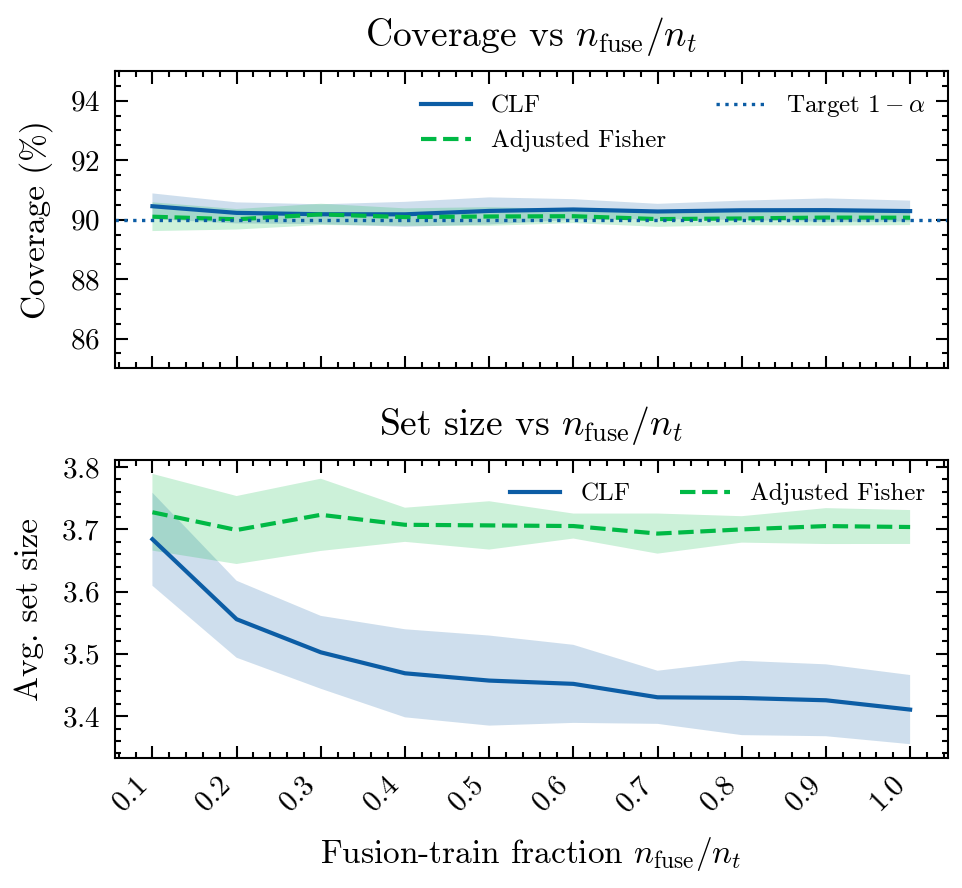

In [4]:
"""
Ablation study (matched to your MAIN CIFAR script):

Goal: vary fusion-train size n_t as a fraction of baseline n_t,
and plot (1) coverage and (2) average set size vs n_t fraction.

MATCHING GUARANTEE (practically):
- For K=4 and nt_frac=1.0, CF (conformal fusion LR) and AdjF should match the MAIN script’s K=4 results,
  because we:
  (i) use the SAME model + SAME train_model as main,
  (ii) use the SAME data splits,
  (iii) consume torch RNG in the SAME order by looping Ks=(2,3,4,6) before recording K=4.

Outputs:
  - ablation_ntfrac_results.csv
  - ablation_ntfrac_agg_K4.csv
  - ablation_ntfrac_cifar10_K4.pdf  (and .png)
"""

from __future__ import annotations

import os
import warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy.stats import chi2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# =========================
# Plot style (scienceplots)
# =========================
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    import scienceplots  # noqa: F401
    plt.style.use(["science", "no-latex"])
except Exception as e:
    print("[WARN] scienceplots not found or style failed; using default matplotlib style.", e)

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams.update(
    {
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 8,
        "axes.titlesize": 9,
        "axes.labelsize": 8,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 6,
        "lines.linewidth": 1.0,
        "axes.linewidth": 0.5,
    }
)

# =========================
# Config
# =========================
@dataclass
class AblationConfig:
    # Match main
    alpha: float = 0.1
    num_classes: int = 10
    num_simulations: int = 10
    epochs_per_view: int = 100
    lr: float = 1e-3
    batch_size: int = 512
    max_iter_lr: int = 1000
    train_seed_base: int = 42

    train_frac: float = 0.5
    cal_frac_of_temp: float = 0.3
    fuse_train_frac_of_rest: float = 0.7

    # Important: match main’s K-loop RNG consumption
    Ks: Tuple[int, ...] = (4,)
    K_target: int = 4

    # Ablation
    nt_fracs: Tuple[float, ...] = tuple(np.round(np.linspace(0.1, 1.0, 10), 2))

    # Output
    out_dir: str = "ablation_outputs"


# =========================
# Torch / Data (match main)
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Match main: seed ONCE globally (do NOT reseed per simulation)
torch.manual_seed(0)
np.random.seed(0)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

X_train_full = train_dataset.data.astype(np.float32) / 255.0
Y_train_full = np.array(train_dataset.targets)
X_test_full  = test_dataset.data.astype(np.float32) / 255.0
Y_test_full  = np.array(test_dataset.targets)


# =========================
# Multi-view (patch) utilities (match main)
# =========================
def split_image_into_k_patches(image: torch.Tensor, k: int) -> List[torch.Tensor]:
    C, H, W = image.shape
    if k == 4:
        patches = []
        for i in range(2):
            for j in range(2):
                patch = image[:, i*16:(i+1)*16, j*16:(j+1)*16]
                patches.append(patch)
        return patches
    else:
        base_width = W // k
        remainder = W % k
        patches, start = [], 0
        for idx in range(k):
            width = base_width + (1 if idx < remainder else 0)
            patch = image[:, :, start:start+width]
            patches.append(patch)
            start += width
        return patches


class PatchesDataset(torch.utils.data.Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, k: int, view: int):
        self.images = images
        self.labels = labels
        self.k = k
        self.view = view

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        img = self.images[idx].transpose((2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)
        patches = split_image_into_k_patches(img, self.k)
        patch = patches[self.view]
        label = int(self.labels[idx])
        return patch, label


# =========================
# Simple CNN per view (match main)
# =========================
class PredictorCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = None
        self.fc2   = None
        self.num_classes = num_classes

    def forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self.forward_features(x)
        if self.fc1 is None:
            b, c, h, w = x.shape
            self.fc1 = nn.Linear(c*h*w, 128).to(x.device)
            self.fc2 = nn.Linear(128, self.num_classes).to(x.device)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


def train_model(model: nn.Module, train_loader, num_epochs=100, lr=1e-3):
    """
    IMPORTANT: This is copied to MATCH YOUR MAIN CODE EXACTLY.
    (Optimizer is created before lazy FC params exist.)
    """
    crit = nn.CrossEntropyLoss()
    opt  = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for ep in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), torch.tensor(yb, dtype=torch.long, device=device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        if (ep+1) % 25 == 0:
            print(f"  epoch {ep+1}/{num_epochs}")
    return model


# =========================
# Conformal utilities (match main)
# =========================
def compute_nonconformity_scores(model: nn.Module, loader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    scores, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs  = F.softmax(logits, dim=1)
            idx    = torch.arange(probs.size(0), device=probs.device)
            true_p = probs[idx, torch.tensor(yb, dtype=torch.long, device=probs.device)]
            s = (1 - true_p).detach().cpu().numpy()
            scores.extend(s)
            labels.extend(yb.numpy())
    return np.asarray(scores, float), np.asarray(labels, int)


def classwise_scores(scores: np.ndarray, labels: np.ndarray, L: int) -> Dict[int, np.ndarray]:
    out = {c: [] for c in range(L)}
    for s, y in zip(scores, labels):
        out[int(y)].append(float(s))
    return {c: np.asarray(v, float) for c, v in out.items()}


def per_view_pvalues_and_probs(
    model: nn.Module, class_scores: Dict[int, np.ndarray], loader, L: int
) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    probs_all = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs  = F.softmax(logits, dim=1).detach().cpu().numpy()
            probs_all.append(probs)
    probs_all = np.vstack(probs_all)

    n = probs_all.shape[0]
    pvals = np.zeros((n, L))
    for y in range(L):
        cal = class_scores.get(y, np.array([]))
        if cal.size == 0:
            pvals[:, y] = 1.0
        else:
            s_test = 1 - probs_all[:, y]
            counts = np.sum(cal[:, None] >= s_test[None, :], axis=0)
            pvals[:, y] = (1 + counts) / (len(cal) + 1)
    return pvals, probs_all


# =========================
# Fusion + baselines (match main)
# =========================
def build_fusion_features(pvals_list: List[np.ndarray], probs_list: List[np.ndarray]) -> np.ndarray:
    blocks = [np.hstack([pvals_list[k], probs_list[k]]) for k in range(len(pvals_list))]
    return np.hstack(blocks)


def fisher_fusion(P_all: np.ndarray) -> np.ndarray:
    eps = 1e-12
    p = np.clip(P_all, eps, 1.0)
    T = -2 * np.sum(np.log(p), axis=0)
    df = 2 * P_all.shape[0]
    return 1 - chi2.cdf(T, df=df)


def adjusted_fisher_fusion(P_train: np.ndarray, y_train: np.ndarray, P_test: np.ndarray, L: int) -> np.ndarray:
    K, _, _ = P_train.shape
    n_test = P_test.shape[1]
    eps = 1e-12
    out = np.zeros((n_test, L))
    for y in range(L):
        idx = np.where(y_train == y)[0]
        if idx.size < 5:
            out[:, y] = fisher_fusion(P_test)[:, y]
            continue
        P_cls = np.clip(P_train[:, idx, y], eps, 1.0)
        W = -2 * np.log(P_cls)
        Wc = W - W.mean(axis=1, keepdims=True)
        Sigma = (Wc @ Wc.T) / max(W.shape[1] - 1, 1)
        var_T = np.sum(Sigma)
        if not np.isfinite(var_T) or var_T <= 0:
            var_T = 4 * K
        f_y = (8.0 * K * K) / var_T
        c_y = var_T / (4 * K)

        P_t = np.clip(P_test[:, :, y], eps, 1.0)
        T_t = -2 * np.sum(np.log(P_t), axis=0)
        out[:, y] = 1 - chi2.cdf(T_t / c_y, df=f_y)
    return out


def fused_class_cal_scores(y_cal: np.ndarray, fused_probs_cal: np.ndarray, L: int) -> Dict[int, np.ndarray]:
    s = 1 - fused_probs_cal[np.arange(len(y_cal)), y_cal]
    out = {c: [] for c in range(L)}
    for sc, yy in zip(s, y_cal):
        out[int(yy)].append(float(sc))
    return {c: np.asarray(v, float) for c, v in out.items()}


def fused_p_values_from_cal(fused_probs: np.ndarray, cal_class_scores: Dict[int, np.ndarray]) -> np.ndarray:
    n, L = fused_probs.shape
    out = np.zeros((n, L))
    for y in range(L):
        cal = cal_class_scores.get(y, np.array([]))
        if cal.size == 0:
            out[:, y] = 1.0
        else:
            s_test = 1 - fused_probs[:, y]
            counts = np.sum(cal[:, None] >= s_test[None, :], axis=0)
            out[:, y] = (1 + counts) / (len(cal) + 1)
    return out


def evaluate_sets(P: np.ndarray, y_true: np.ndarray, alpha: float) -> Tuple[float, float]:
    C = (P > alpha)
    cov = float(np.mean(C[np.arange(len(y_true)), y_true]))
    size = float(np.mean(C.sum(axis=1)))
    return cov, size


# =========================
# Subsampling helper
# =========================
def stratified_subsample_indices(y: np.ndarray, n_sub: int, seed: int) -> np.ndarray:
    n = len(y)
    n_sub = int(max(1, min(n_sub, n)))
    idx_all = np.arange(n, dtype=int)

    if n_sub >= n:
        return idx_all

    idx_sub, _ = train_test_split(
        idx_all,
        train_size=n_sub,
        stratify=y,
        random_state=seed,
    )
    return np.asarray(idx_sub, dtype=int)


# =========================
# Main ablation
# =========================
def run_ablation(cfg: AblationConfig) -> pd.DataFrame:
    os.makedirs(cfg.out_dir, exist_ok=True)

    rows = []

    for sim in range(cfg.num_simulations):
        print(f"\n=== Simulation {sim+1}/{cfg.num_simulations} ===")
        seed = cfg.train_seed_base + sim

        # Splits EXACTLY like main (done once per sim, shared across all K)
        X_trP, X_tmp, y_trP, y_tmp = train_test_split(
            X_train_full, Y_train_full,
            test_size=1 - cfg.train_frac,
            stratify=Y_train_full,
            random_state=seed,
        )
        X_cal, X_rest, y_cal, y_rest = train_test_split(
            X_tmp, y_tmp,
            test_size=1 - cfg.cal_frac_of_temp,
            stratify=y_tmp,
            random_state=seed,
        )
        X_fuse_tr_full, X_fuse_cal, y_fuse_tr_full, y_fuse_cal = train_test_split(
            X_rest, y_rest,
            test_size=1 - cfg.fuse_train_frac_of_rest,
            stratify=y_rest,
            random_state=seed,
        )
        X_te, y_te = X_test_full, Y_test_full

        # IMPORTANT: loop Ks like main to match RNG state when K=4 begins
        for K in cfg.Ks:
            print(f"\n  -> K = {K}")
            num_views = 4 if K == 4 else K

            # DataLoaders per view (match main)
            loaders = {}
            for v in range(num_views):
                tr_loader = torch.utils.data.DataLoader(
                    PatchesDataset(X_trP, y_trP, K, v),
                    batch_size=cfg.batch_size,
                    shuffle=True,
                )
                cal_loader = torch.utils.data.DataLoader(
                    PatchesDataset(X_cal, y_cal, K, v),
                    batch_size=cfg.batch_size,
                    shuffle=False,
                )
                ftr_loader = torch.utils.data.DataLoader(
                    PatchesDataset(X_fuse_tr_full, y_fuse_tr_full, K, v),
                    batch_size=cfg.batch_size,
                    shuffle=False,
                )
                fcal_loader = torch.utils.data.DataLoader(
                    PatchesDataset(X_fuse_cal, y_fuse_cal, K, v),
                    batch_size=cfg.batch_size,
                    shuffle=False,
                )
                te_loader = torch.utils.data.DataLoader(
                    PatchesDataset(X_te, y_te, K, v),
                    batch_size=cfg.batch_size,
                    shuffle=False,
                )
                loaders[v] = dict(train=tr_loader, cal=cal_loader, ftr=ftr_loader, fcal=fcal_loader, te=te_loader)

            # Train per-view CNNs (match main)
            models: List[PredictorCNN] = []
            cal_classwise: List[Dict[int, np.ndarray]] = []
            for v in range(num_views):
                print(f"    [View {v+1}/{num_views}] training...")
                m = PredictorCNN(num_classes=cfg.num_classes)
                m = train_model(m, loaders[v]["train"], num_epochs=cfg.epochs_per_view, lr=cfg.lr)
                models.append(m)

                sc, lab = compute_nonconformity_scores(m, loaders[v]["cal"])
                cal_classwise.append(classwise_scores(sc, lab, cfg.num_classes))

            # Per-view p/probs for fusion train/cal/test (match main)
            pv_tr_full, pr_tr_full = [], []
            pv_cal2,    pr_cal2    = [], []
            pv_te,      pr_te      = [], []
            for v in range(num_views):
                p, pr = per_view_pvalues_and_probs(models[v], cal_classwise[v], loaders[v]["ftr"], cfg.num_classes)
                pv_tr_full.append(p); pr_tr_full.append(pr)

                p, pr = per_view_pvalues_and_probs(models[v], cal_classwise[v], loaders[v]["fcal"], cfg.num_classes)
                pv_cal2.append(p); pr_cal2.append(pr)

                p, pr = per_view_pvalues_and_probs(models[v], cal_classwise[v], loaders[v]["te"], cfg.num_classes)
                pv_te.append(p); pr_te.append(pr)

            # If this isn't the target K, we stop here (but we already consumed RNG exactly like main)
            if K != cfg.K_target:
                continue

            # Target K: run ablation on fusion LR + AdjF
            P_test = np.stack(pv_te, axis=0)  # (K, n_test, L)
            n_t_full = len(y_fuse_tr_full)

            # Precompute fixed features for cal2 and test (cal2 stays fixed across fracs)
            X_cal2_feat = build_fusion_features(pv_cal2, pr_cal2)
            X_test_feat = build_fusion_features(pv_te, pr_te)

            for frac in cfg.nt_fracs:
                n_sub = int(round(frac * n_t_full))
                idx_sub = stratified_subsample_indices(
                    y_fuse_tr_full, n_sub, seed=seed + int(frac * 1000)
                )

                y_tr_sub = y_fuse_tr_full[idx_sub]
                pv_tr_sub = [pv[idx_sub] for pv in pv_tr_full]
                pr_tr_sub = [pr[idx_sub] for pr in pr_tr_full]

                # CF (fusion LR) trained on subset, calibrated on full cal2
                X_ftr_sub = build_fusion_features(pv_tr_sub, pr_tr_sub)
                fusion_lr = LogisticRegression(
                    max_iter=cfg.max_iter_lr,
                    multi_class="multinomial",
                    solver="lbfgs",
                    random_state=seed,
                )
                fusion_lr.fit(X_ftr_sub, y_tr_sub)

                fused_probs_cal2 = fusion_lr.predict_proba(X_cal2_feat)
                fused_cal_scores = fused_class_cal_scores(y_fuse_cal, fused_probs_cal2, cfg.num_classes)

                fused_probs_test = fusion_lr.predict_proba(X_test_feat)
                P_cf = fused_p_values_from_cal(fused_probs_test, fused_cal_scores)
                cov_cf, size_cf = evaluate_sets(P_cf, y_te, cfg.alpha)

                # AdjF depends on subset too
                P_train_sub = np.stack(pv_tr_sub, axis=0)
                P_adjF = adjusted_fisher_fusion(P_train_sub, y_tr_sub, P_test, cfg.num_classes)
                cov_adjF, size_adjF = evaluate_sets(P_adjF, y_te, cfg.alpha)

                rows.append(
                    dict(
                        sim=sim,
                        seed=seed,
                        K=K,
                        alpha=cfg.alpha,
                        nt_frac=float(frac),
                        nt_sub=int(len(idx_sub)),
                        nt_full=int(n_t_full),
                        cov_cf=float(cov_cf),
                        size_cf=float(size_cf),
                        cov_adjF=float(cov_adjF),
                        size_adjF=float(size_adjF),
                    )
                )
                print(
                    f"    nt_frac={frac:.2f} (n={len(idx_sub):5d}) | "
                    f"CF: cov={cov_cf:.3f}, size={size_cf:.3f} | "
                    f"AdjF: cov={cov_adjF:.3f}, size={size_adjF:.3f}"
                )

    df = pd.DataFrame(rows)
    out_csv = os.path.join(cfg.out_dir, "ablation_ntfrac_results.csv")
    df.to_csv(out_csv, index=False)
    print(f"\nSaved raw results to: {out_csv}")
    return df


def plot_ablation(df: pd.DataFrame, cfg: AblationConfig):
    g = df.groupby("nt_frac").agg(
        cov_cf_mean=("cov_cf", "mean"),
        cov_cf_std=("cov_cf", "std"),
        size_cf_mean=("size_cf", "mean"),
        size_cf_std=("size_cf", "std"),
        cov_adjF_mean=("cov_adjF", "mean"),
        cov_adjF_std=("cov_adjF", "std"),
        size_adjF_mean=("size_adjF", "mean"),
        size_adjF_std=("size_adjF", "std"),
        nt_sub_mean=("nt_sub", "mean"),
    ).reset_index().sort_values("nt_frac")

    out_agg = os.path.join(cfg.out_dir, f"ablation_ntfrac_agg_K{cfg.K_target}.csv")
    g.to_csv(out_agg, index=False)
    print(f"Saved aggregated table to: {out_agg}")

    x = g["nt_frac"].to_numpy()

    # ---- one-column figure: 2 rows x 1 col ----
    # Typical one-column width ~3.3–3.5 inches; height tuned for two stacked panels.
    fig, axes = plt.subplots(2, 1, figsize=(3.35, 3.10), dpi=300, sharex=True)

    xlab = r"Fusion-train fraction $n_{\mathrm{fuse}} / n_t$"

    # =========================
    # Coverage
    # =========================
    ax = axes[0]
    ax.plot(x, 100.0 * g["cov_cf_mean"], label="CLF")
    ax.fill_between(
        x,
        100.0 * (g["cov_cf_mean"] - g["cov_cf_std"].fillna(0)),
        100.0 * (g["cov_cf_mean"] + g["cov_cf_std"].fillna(0)),
        alpha=0.2,
        linewidth=0.0,
    )
    ax.plot(x, 100.0 * g["cov_adjF_mean"], label="Adjusted Fisher", linestyle="--")
    ax.fill_between(
        x,
        100.0 * (g["cov_adjF_mean"] - g["cov_adjF_std"].fillna(0)),
        100.0 * (g["cov_adjF_mean"] + g["cov_adjF_std"].fillna(0)),
        alpha=0.2,
        linewidth=0.0,
    )
    ax.axhline(
        100.0 * (1.0 - cfg.alpha),
        linestyle=":",
        linewidth=0.8,
        label=r"Target $1-\alpha$",
    )
    ax.set_ylabel("Coverage (%)")
    ax.set_title(r"Coverage vs $n_{\mathrm{fuse}}/n_t$")
    ax.set_ylim(100.0 * (1.0 - cfg.alpha) - 5.0, 100.0 * (1.0 - cfg.alpha) + 5.0)
    ax.legend(frameon=False, ncol=2)

    # =========================
    # Set size
    # =========================
    ax = axes[1]
    ax.plot(x, g["size_cf_mean"], label="CLF")
    ax.fill_between(
        x,
        (g["size_cf_mean"] - g["size_cf_std"].fillna(0)),
        (g["size_cf_mean"] + g["size_cf_std"].fillna(0)),
        alpha=0.2,
        linewidth=0.0,
    )
    ax.plot(x, g["size_adjF_mean"], label="Adjusted Fisher", linestyle="--")
    ax.fill_between(
        x,
        (g["size_adjF_mean"] - g["size_adjF_std"].fillna(0)),
        (g["size_adjF_mean"] + g["size_adjF_std"].fillna(0)),
        alpha=0.2,
        linewidth=0.0,
    )
    ax.set_xlabel(xlab)
    ax.set_ylabel("Avg. set size")
    ax.set_title(r"Set size vs $n_{\mathrm{fuse}}/n_t$")
    ax.legend(frameon=False, ncol=2)

    # x ticks: keep but reduce crowding for small width
    ax.set_xticks(x)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha("right")

    fig.tight_layout()

    out_pdf = os.path.join(cfg.out_dir, f"ablation_ntfrac_cifar10_K{cfg.K_target}.pdf")
    out_png = os.path.join(cfg.out_dir, f"ablation_ntfrac_cifar10_K{cfg.K_target}.png")
    fig.savefig(out_pdf, bbox_inches="tight")
    fig.savefig(out_png, bbox_inches="tight")
    print(f"Saved figure to:\n  {out_pdf}\n  {out_png}")

    plt.show()



cfg = AblationConfig()
df = run_ablation(cfg)
plot_ablation(df, cfg)